In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
dataset_name = "playground-series-s3e20"

In [3]:
raw_df = pd.read_csv('./data/train.csv')

In [21]:
features = raw_df.columns.drop(['id', 'prognosis']).tolist()

In [4]:
labels = raw_df["prognosis"].unique()
label_encoder = LabelEncoder()
df = raw_df.copy()
df['label'] = label_encoder.fit_transform(df['prognosis'])
idx2label = {index: label for index, label in enumerate(label_encoder.classes_)}
label2idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}

In [5]:
labels_list = sorted(df['label'].unique().tolist())

In [6]:
target = df['label']
data = df.drop(columns=['id', 'label', 'prognosis'])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)
y_val_categories = [idx2label[label] for label in y_val]

In [8]:
def average_precision(y_true, y_scores, k):
    """
    Вычисляет Average Precision для одного запроса.
    
    y_true: Список истинных меток (0 и 1), где 1 - это релевантные документы.
    y_scores: Список оценок (например, вероятностей) для документов.
    k: Количество верхних результатов, учитываемых для вычисления.
    return: Средняя точность (AP) для данного запроса.
    """
    # Получаем индексы, по которым отсортированы y_scores
    indices = np.argsort(y_scores)[::-1][:k]  # сортировка по убыванию и берем первые k
    relevant = np.array(y_true)[indices]  # соответствующие истинные метки
    relevant_count = np.cumsum(relevant)  # количество релевантных документов на каждой позиции
    
    # Вычисляем точность для каждого из top-k
    precisions_at_k = relevant_count / (np.arange(1, k + 1))
    
    # Average Precision (AP)
    if relevant_count.sum() == 0:  # если нет релевантных документов
        return 0.0

    average_precision = (precisions_at_k * relevant).sum() / relevant_count.sum()
    return average_precision

def mean_average_precision(y_true_list, y_scores_list, k):
    """
    Вычисляет Mean Average Precision (MAP) для списка запросов.
    
    y_true_list: Список списков истинных меток для всех запросов.
    y_scores_list: Список списков оценок для всех запросов.
    k: Количество верхних результатов, учитываемых для вычисления.
    return: Mean Average Precision (MAP) для всех запросов.
    """
    ap_list = []
    for y_true, y_scores in zip(y_true_list, y_scores_list):
        ap = average_precision(y_true, y_scores, k)
        ap_list.append(ap)
    
    return np.mean(ap_list)

def get_y_true(label_idx: int, labels_list: list):
    '''
    По переданной метке генерирует список истинных меток 
    (по факту, просто возвращает список, где на месте истинной метки стоит 1, все остальные 0)

    label: значение истинной метки (категориальная величина)
    label2idx: словарь отображения категориальных меток в численные
    '''
    y_true = [0 for _ in labels_list]
    y_true[label_idx] = 1
    return y_true

def get_y_true_list(labels: list, labels_list: list):
    '''
    По переданному массиву категориальных меток генерирует список списков 
    истенных меток для применения в mean_average_precision.
    '''
    y_true_list = []
    for label in labels:
        y_true = get_y_true(label, labels_list)
        y_true_list.append(y_true)

    return y_true_list

def get_score(y_pred, y_test, labels_list, k=3):
    y_true_list = get_y_true_list(y_test, labels_list)
    y_scores_list = get_y_true_list(y_pred, labels_list)
    return mean_average_precision(y_true_list, y_scores_list, k)

In [9]:
# у нас есть небольшой дисбаланс в классах, можно задать class_weight
label_counts = y_train.value_counts()
total_count = len(df)
class_weights = {label: total_count / count for label, count in label_counts.items()}
class_weights

{8: 10.552238805970148,
 2: 11.046875,
 7: 12.189655172413794,
 6: 12.189655172413794,
 1: 12.403508771929825,
 0: 13.092592592592593,
 9: 15.369565217391305,
 10: 15.71111111111111,
 3: 17.24390243902439,
 4: 18.605263157894736,
 5: 19.10810810810811}

# TODO: проверить, как отработает модель, если не задавать распределение признаков

# TODO: для SVM потюнить параметр, который отвечает за SoftMax SVM

Как можно предсказывать вероятности с помощью SVM
```
# Создаем модель SVC с probability=True
model = SVC(probability=True)
model.fit(X_train, y_train)

# Получаем вероятности
probs = model.predict_proba(X_test)
print(probs)
```

In [ ]:
# param_grid = {
#     'C': [0.01, 0.1, 0.5, 1, 10],
#     'gamma': ['scale', 'auto', 0.01, 0.1, 0.5, 1,],
#     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'degree' : range(2, 10+1),
#     'decision_function_shape' : ['ovr', 'ovo']
# }

# grid_search = GridSearchCV(SVC(class_weight=class_weights), param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Лучшие параметры: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

In [14]:
best_svm_model = SVC(kernel="rbf", C=0.1, gamma=0.1, class_weight=class_weights, decision_function_shape='ovr', degree=2, probability=True)
best_svm_model.fit(X_train, y_train)

SVC(C=0.1,
    class_weight={0: 13.092592592592593, 1: 12.403508771929825, 2: 11.046875,
                  3: 17.24390243902439, 4: 18.605263157894736,
                  5: 19.10810810810811, 6: 12.189655172413794,
                  7: 12.189655172413794, 8: 10.552238805970148,
                  9: 15.369565217391305, 10: 15.71111111111111},
    degree=2, gamma=0.1, probability=True)

In [16]:
probabilities = best_svm_model.predict_proba(X_val)
probabilities

array([[0.19465695, 0.21344019, 0.13514578, ..., 0.05318509, 0.08848554,
        0.04822618],
       [0.03029573, 0.25740596, 0.10638858, ..., 0.21137304, 0.03484205,
        0.02200532],
       [0.01354888, 0.21709587, 0.10211161, ..., 0.15349647, 0.03569057,
        0.03125656],
       ...,
       [0.00972158, 0.131927  , 0.13960197, ..., 0.2076065 , 0.06578589,
        0.07255152],
       [0.01272008, 0.14490053, 0.03320108, ..., 0.02521635, 0.01325525,
        0.0084671 ],
       [0.00656776, 0.02404393, 0.10798382, ..., 0.25132062, 0.10349935,
        0.07044242]])

In [17]:
y_scores = best_svm_model.predict(X_val)
svm_map_score = get_score(y_scores, y_val, labels_list, k=3)
svm_map_score

np.float64(0.15316901408450703)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_scores)) 

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.23      0.50      0.32         6
           2       0.00      0.00      0.00        17
           3       0.47      0.64      0.54        11
           4       0.25      0.30      0.27        10
           5       0.25      0.06      0.10        16
           6       0.25      0.17      0.20        12
           7       0.56      0.75      0.64        12
           8       0.26      0.28      0.27        18
           9       0.22      0.40      0.29        15
          10       0.25      0.15      0.19        13

    accuracy                           0.33       142
   macro avg       0.31      0.36      0.32       142
weighted avg       0.30      0.33      0.30       142



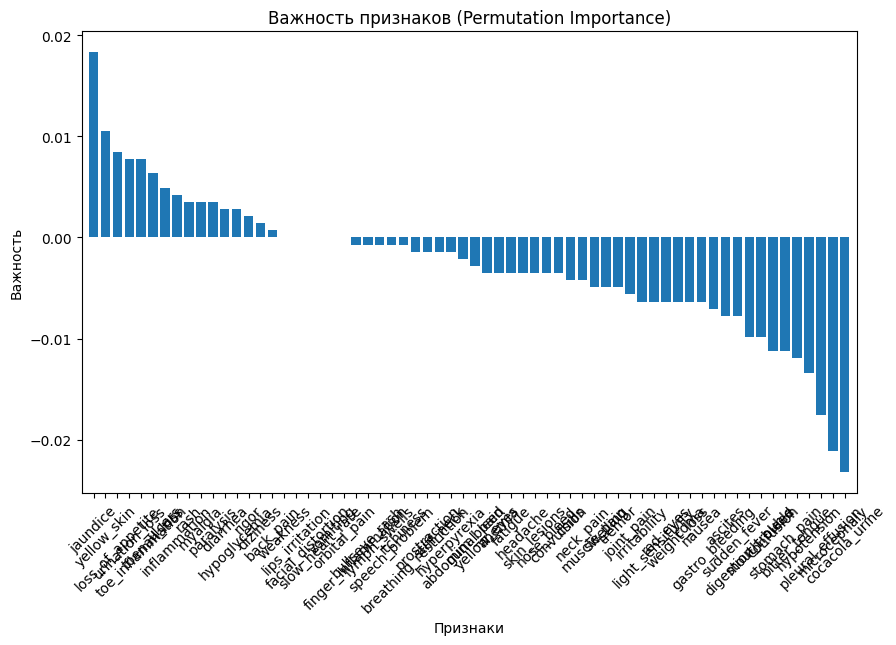

In [22]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Оценка важности признаков методом перестановки
result = permutation_importance(best_svm_model, X_val, y_val, n_repeats=10, random_state=42)

# Построение графика важности признаков
importance = result.importances_mean
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков (Permutation Importance)")
plt.bar(range(X_val.shape[1]), importance[indices], align="center")
plt.xticks(range(X_val.shape[1]), np.array(features)[indices], rotation=45)
plt.xlim([-1, X_val.shape[1]])
plt.ylabel('Важность')
plt.xlabel('Признаки')
plt.show()

In [24]:
import xgboost as xgb

In [ ]:
# param_grid = {
#     "max_depth" : [1, 2, 4, 5, 8], 
#     "n_estimators": [100, 110, 120, 150],
#     # "booster": ['gbtree', 'dart'],
#     # 'learning_rate': [0.01, 0.05, 0.1, 0.5],
#     'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1, 10], # коэф. L1 регуляризации
#     'reg_lambda' : [0.01, 0.05, 0.1, 0.5, 1, 10]
# }

# boost_model = xgb.XGBClassifier(objective='multi:softprob') # для многоклассовой классификации

# grid_search = GridSearchCV(boost_model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': 1, 'n_estimators': 120, 'reg_alpha': 0.01, 'reg_lambda': 10}


In [25]:
best_boost_model = xgb.XGBClassifier(objective='multi:softprob', max_depth=1, n_estimators=120, reg_alpha=0.01, reg_lambda=10)
best_boost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
y_scores = best_boost_model.predict(X_val)
svm_map_score = get_score(y_scores, y_val, labels_list, k=3)
svm_map_score

np.float64(0.13732394366197184)

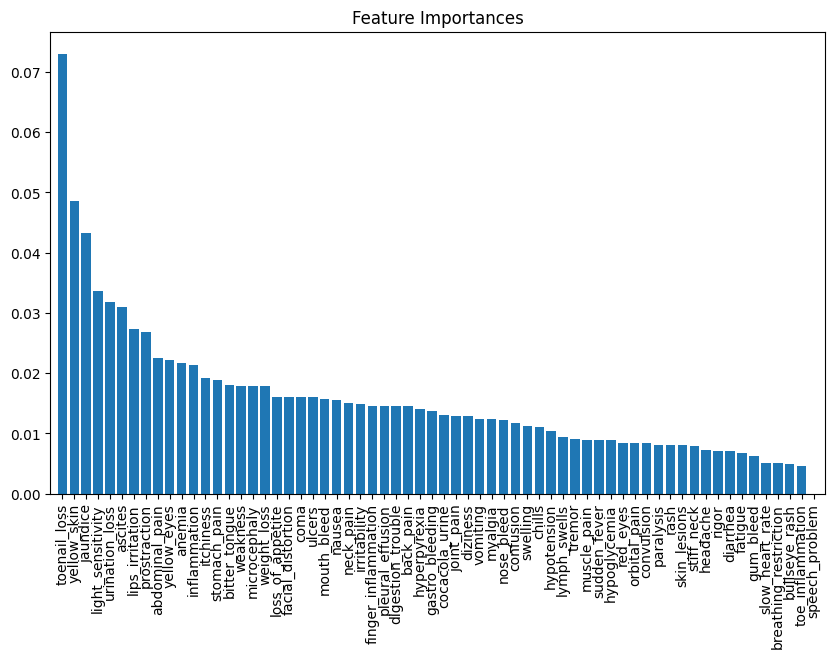

In [26]:
import matplotlib.pyplot as plt

# Получаем важность признаков
importances = best_boost_model.feature_importances_

# Признаки (если у вас есть имена признаков)
feature_names = X_train.columns  # если X - это DataFrame

# Создаем данные для визуализации
indices = np.argsort(importances)[::-1]  # индексы признаков по убыванию

n_features = X_train.shape[1]

# Визуализация
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(n_features), importances[indices], align="center")
plt.xticks(range(n_features), feature_names[indices], rotation=90)
plt.xlim([-1, n_features])
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression

# Инициализация модели Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear')

# Определение параметров для подбора
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Регуляризация
    'max_iter': [100, 200, 300]            # Количество итераций
}

# Инициализация GridSearchCV для поиска наилучших параметров
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели с подбором параметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

Лучшие параметры: {'C': 0.1, 'max_iter': 100}


/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

In [29]:
logestic_regression_model = LogisticRegression(multi_class='ovr', solver='liblinear', C=0.1, max_iter=100)
logestic_regression_model.fit(X_train, y_train)

/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.1, multi_class='ovr', solver='liblinear')

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('best_svm',                best_svm_model),
    ('best_boosting_model',    best_boost_model),
    ('linear_regression_model', logestic_regression_model)
]

stack_model= StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

In [33]:
stack_model.fit(X_train, y_train)

/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/pavel/Projects/Study/KaggleCompetition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

StackingClassifier(estimators=[('best_svm',
                                SVC(C=0.1,
                                    class_weight={0: 13.092592592592593,
                                                  1: 12.403508771929825,
                                                  2: 11.046875,
                                                  3: 17.24390243902439,
                                                  4: 18.605263157894736,
                                                  5: 19.10810810810811,
                                                  6: 12.189655172413794,
                                                  7: 12.189655172413794,
                                                  8: 10.552238805970148,
                                                  9: 15.369565217391305,
                                                  10: 15.71111111111111},
                                    degree=2, gamma=0.1, probability=True)),
                               ('best_boosting_model',
                                X...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=1,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=120, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...)),
                               ('linear_regression_model',
                                LogisticRegression(C=0.1, multi_class='ovr',
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression())

In [34]:
y_scores = stack_model.predict(X_val)
svm_map_score = get_score(y_scores, y_val, labels_list, k=3)
svm_map_score

np.float64(0.14847417840375585)